# Using models from Tensorflow Hub

## Importing a model

In [2]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")
embeddings = embed(["cat is on the mat", "dog is in the fog"])

print(embeddings)

2024-05-11 18:22:24.279999: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf.Tensor(
[[-5.14805540e-02 -1.92053974e-01  4.53008525e-02 -9.96370390e-02
   5.38923480e-02  8.34979564e-02  7.27996677e-02 -1.27169073e-01
   6.24356270e-02  9.81895104e-02 -5.33969402e-02  1.61190659e-01
  -1.36027522e-02 -2.72708107e-03  1.71537384e-01  1.24906197e-01
   1.15381563e-02 -2.77321301e-02  6.66442439e-02 -1.28565924e-02
   3.95655632e-02  1.61706526e-02  3.44905234e-03 -3.30653414e-02
   1.13467865e-01 -3.23929265e-02  6.64588250e-03  5.34387156e-02
   1.19479060e-01  4.63577174e-02  8.30192715e-02 -5.91111630e-02
   8.59290361e-02 -1.01532824e-01  7.54378317e-03  4.15412569e-03
   5.89248538e-03 -2.51556151e-02  1.13079183e-01 -4.36960533e-02
  -1.68391705e-01  2.92641334e-02 -1.40178025e-01 -8.40619281e-02
   1.48394153e-01  9.07467008e-02 -5.67608029e-02 -1.04004763e-01
  -8.44553933e-02  8.50597844e-02  7.93245584e-02  2.39145532e-02
  -1.19153991e-01  2.17635736e-01 -2.18595695e-02 -4.27431203e-02
  -1.75292030e-01 -5.83514608e-02  1.50858937e-02 -9.78629012e-03

## Using the model for classification

### Reading the dataset and initial settings

In [2]:
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

dataset=pd.read_csv("IMDB_Dataset.csv")

NB_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 50  # Size of the batches used in the mini-batch gradient descent
PATIENCE=10 # Patience level
DROP_RATE=0.4 # Dropout rate


dataset['review']=dataset['review'].map(strip_html)

/var/folders/pg/ykf3591d58z1z4kgmjn1k1040000gn/T/ipykernel_48099/2495926660.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### Creating the sets

In [3]:
X_trainAll, X_test, y_trainAll, y_test = train_test_split(dataset['review'], dataset['sentiment'],
                                                          test_size=0.10, random_state=10)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainAll, y_trainAll,
                                                      test_size=0.20, random_state=10)

le = LabelEncoder()
y_train_le=le.fit_transform(y_train)
y_valid_le=le.transform(y_valid)
y_test_le=le.transform(y_test)


### Creating the network

In [4]:
import tf_keras as keras
import tensorflow_hub as hub
import tensorflow as tf

hub_layer = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-250/2",
                           input_shape=[], dtype=tf.string,trainable=False)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dropout(DROP_RATE))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(DROP_RATE))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(DROP_RATE))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 250)               252343750 
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 128)               32128     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1

### Fitting

In [11]:

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=PATIENCE,
                                            restore_best_weights=True)
tb_callback = keras.callbacks.TensorBoard('./logs', update_freq=1)
history = model.fit(X_train, y_train_le, epochs=NB_EPOCHS,\
                    validation_data=(X_valid, y_valid_le), \
                        callbacks=[early_stopping_cb, checkpoint_cb,tb_callback],batch_size=BATCH_SIZE)

Epoch 1/20
720/720 [==============================] - 14s 19ms/step - loss: 0.5811 - accuracy: 0.6970 - val_loss: 0.5372 - val_accuracy: 0.7497
Epoch 2/20
720/720 [==============================] - 6s 9ms/step - loss: 0.5805 - accuracy: 0.6967 - val_loss: 0.5512 - val_accuracy: 0.7367
Epoch 3/20
720/720 [==============================] - 6s 8ms/step - loss: 0.5813 - accuracy: 0.6988 - val_loss: 0.5376 - val_accuracy: 0.7563
Epoch 4/20
720/720 [==============================] - 6s 8ms/step - loss: 0.5813 - accuracy: 0.6959 - val_loss: 0.5446 - val_accuracy: 0.7451
Epoch 5/20
720/720 [==============================] - 6s 8ms/step - loss: 0.5782 - accuracy: 0.6998 - val_loss: 0.5410 - val_accuracy: 0.7391
Epoch 6/20
720/720 [==============================] - 6s 9ms/step - loss: 0.5808 - accuracy: 0.6955 - val_loss: 0.5378 - val_accuracy: 0.7446
Epoch 7/20
720/720 [==============================] - 6s 8ms/step - loss: 0.5826 - accuracy: 0.6954 - val_loss: 0.5472 - val_accuracy: 0.7482
Epoc

### Evaluating

Training Accuracy: 0.7380
157/157 [==============================] - 1s 4ms/step - loss: 0.5237 - accuracy: 0.7448
Testing Accuracy:  0.7448


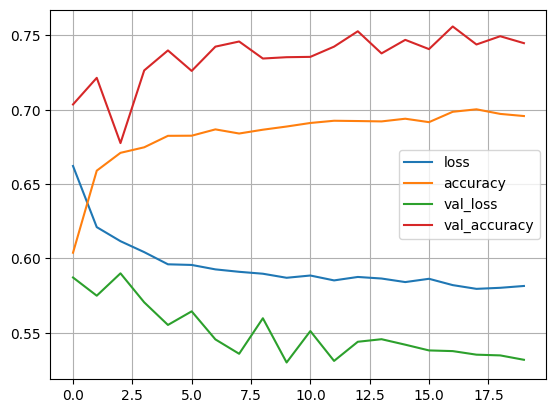

In [9]:
loss, accuracy = model.evaluate(X_train, y_train_le, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test_le, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()